Exercise 62

5.1 Deep GNN

This exercise is about setting up networks with several convolutional GNN layers. Also a head will be added to process the node representations before aggregation. The datafiles can be downloaded from Brightspace.

5.2 Datasets

The data is loaded like this:

In [4]:
import numpy as np

data = np.load('dataset_for_exercise_62/nn_nnn_clusters_6.npz')

And the i'the datapoint is converted into a Torch Geometric graph by calling this function:

In [ ]:
import torch
from torch_geometric.data import Data

def get_graph(index, cutoff=2.5, box_size=10):

    positions = data['positions'][index]
    positions = torch.vstack([torch.tensor(p,dtype=torch.float32) for p in positions])
    D = torch.cdist(positions, positions)

    edge_index = []
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if i == j:
                continue
            if D[i, j] < cutoff:
                edge_index.append([i, j])

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)

    x = torch.ones((positions.shape[0], 1),dtype=torch.float32)
    y = torch.tensor(data['energies'][index],dtype=torch.float32)
    return Data(edge_index=edge_index, pos=positions, x=x, y=y)


Data(x=[6, 1], edge_index=[2, 16], y=-19.0, pos=[6, 2])

b) Plot every 10th of the loaded graphs:

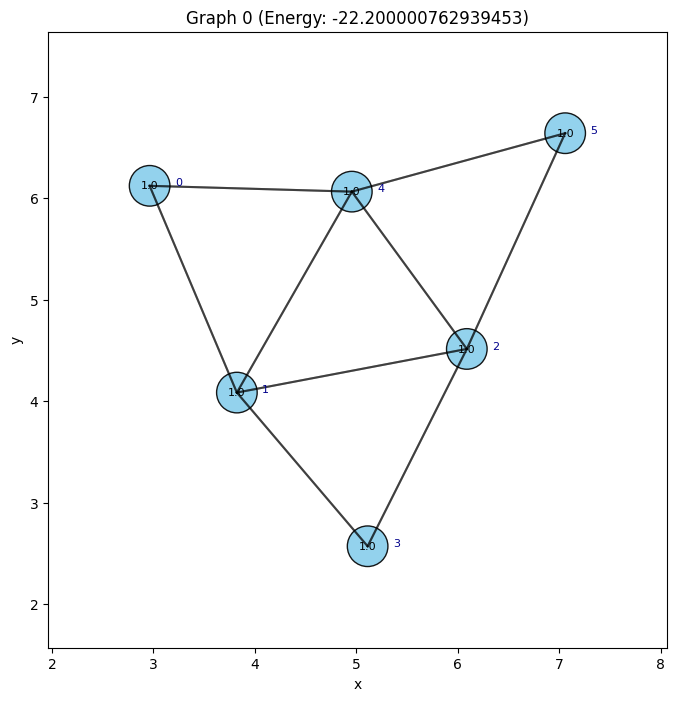

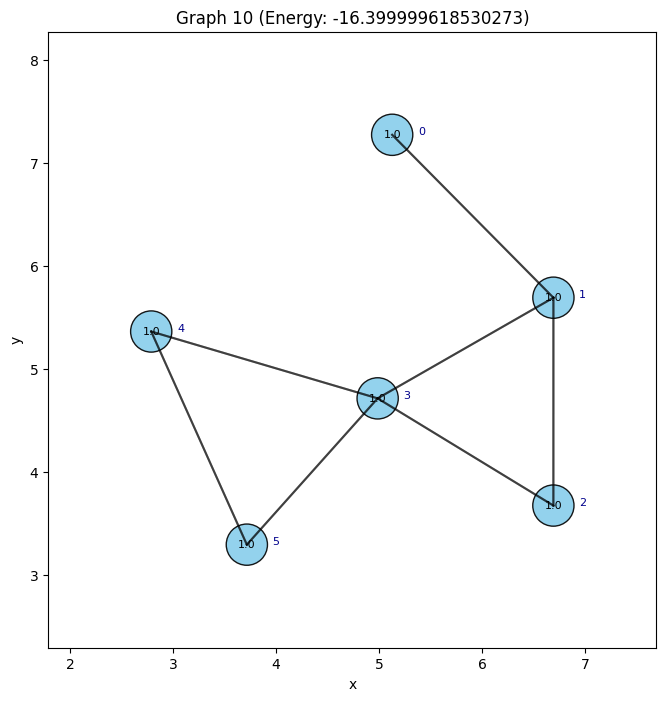

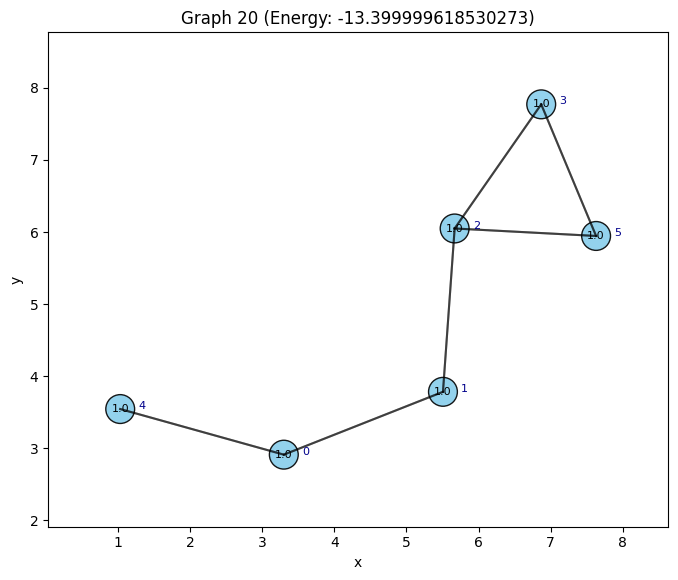

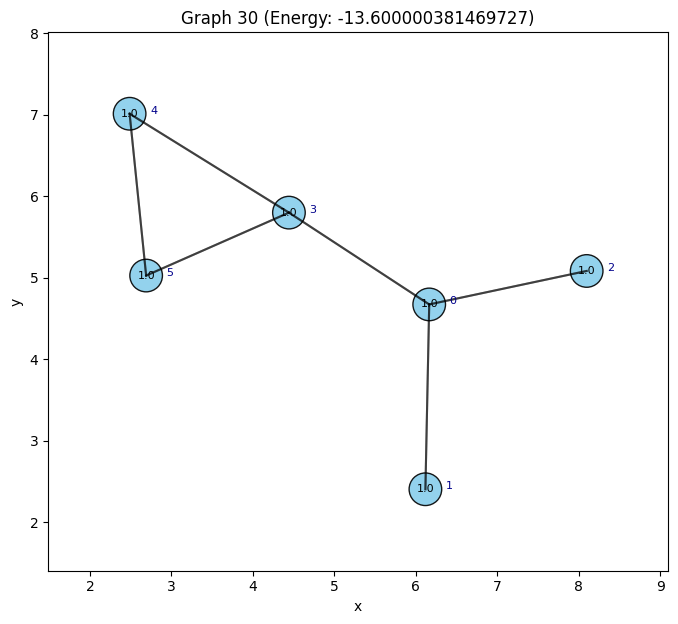

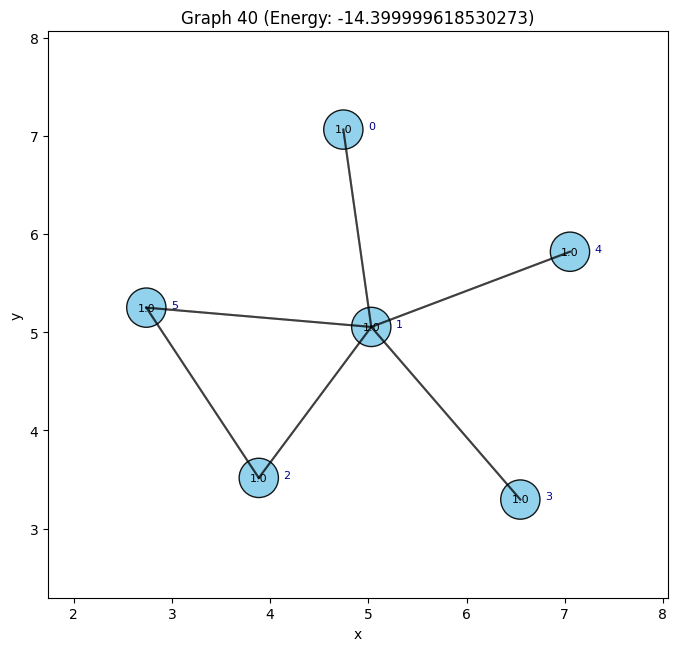

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data

def plot_graph(graph, title=None):
    """Plot the graph with nodes as circles, attribute values inside, and labels next to them."""
    pos = graph.pos.numpy()
    edge_index = graph.edge_index.numpy()
    attributes = graph.x.numpy().flatten()  # Node attributes
    label = graph.y.item()  # Graph label, assuming scalar

    plt.figure(figsize=(8, 8))
    
    # Plot edges
    for i, j in edge_index.T:
        plt.plot([pos[i, 0], pos[j, 0]], [pos[i, 1], pos[j, 1]], 'k-', alpha=0.5)

    # Plot nodes as circles
    for i, (x, y) in enumerate(pos):
        circle = plt.Circle((x, y), 0.2, color='skyblue', ec='black', alpha=0.9)
        plt.gca().add_patch(circle)
        plt.text(x, y, f"{attributes[i]:.1f}", fontsize=8, ha='center', va='center', color='black')  # Attribute inside

        # Label next to the circle
        plt.text(x + 0.25, y, f"{i}", fontsize=8, color='darkblue')

    # Set axis limits
    plt.xlim(pos[:, 0].min() - 1, pos[:, 0].max() + 1)
    plt.ylim(pos[:, 1].min() - 1, pos[:, 1].max() + 1)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.title(f"{title} (Energy: {label})" if title else f"Graph (Label: {label})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

# Example loop for plotting every 10th graph
for i in range(0, len(data['positions']), 10):
    graph = get_graph(i)  # Generate the graph
    plot_graph(graph, title=f"Graph {i}")


5.3 Fit with one message

c) Set up a model with a single Convolutional GNN layer with ψ and ϕ having one neuron each. Let the model aggregate the node values to produce one number per graph. Fit the model so that it reproduces the y-values on the graph as good as possible. Construct the parity plot:

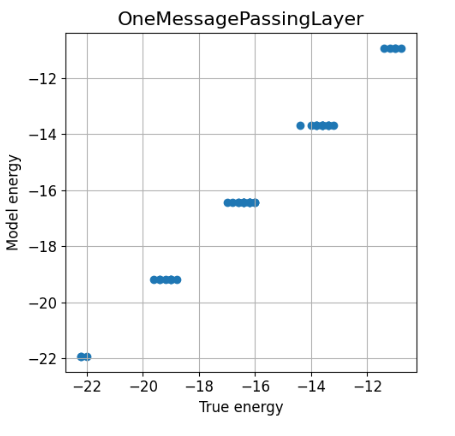

In [ ]:
import torch
from torch.nn import Linear, SiLU
from torch_geometric.nn import MessagePassing

class PhiPsiGNN(MessagePassing):
    def __init__(self, d_in, d_out, d_message=None, aggr='add'):
        super().__init__(aggr=aggr)
        if d_message is None:
            d_message = d_in
        self.psi = torch.nn.Linear(d_in, d_message),
        # Define phi as a linear layer that aggregates the input and message
        self.phi = Linear(d_in + d_message, d_out)

    def forward(self, x, edge_index):
        aggregated_messages = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        # Concatenate node features with aggregated messages and apply phi
        x = self.phi(torch.cat([x, aggregated_messages], dim=-1))
        return x

    def message(self, e_j):
        return 1



d) Plot the local representation on each node right before the aggregation to a global value takes place:

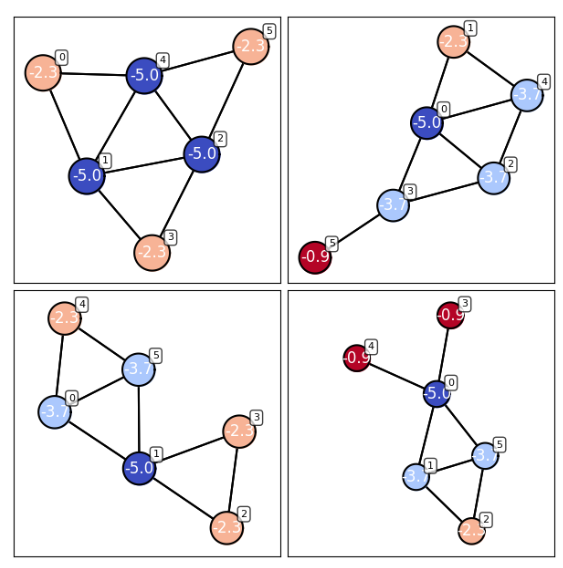

Notice how e.g. the dark blue nodes all have the attribute −5.